In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale
import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier
import optuna
import matplotlib.pyplot as plt
import pins
import os
import random
import shap
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
shap.initjs()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
board = pins.board_folder(os.getcwd())
train = board.pin_read('hc_train')

In [4]:
train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,data_split
0,231376,0,Cash loans,M,Y,Y,0,67500.0,355536.0,15790.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,TRAIN
1,231377,1,Cash loans,F,N,Y,0,112500.0,545040.0,25537.5,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,TRAIN
2,231378,0,Cash loans,M,Y,Y,0,135000.0,463500.0,30973.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
3,231379,0,Revolving loans,F,N,Y,1,180000.0,540000.0,27000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
4,231381,0,Cash loans,F,N,Y,0,135000.0,459000.0,28210.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN


In [5]:
cols = np.arange(2, train.shape[1]).tolist()
train.iloc[:, cols]

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,data_split
0,Cash loans,M,Y,Y,0,67500.0,355536.0,15790.5,270000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,TRAIN
1,Cash loans,F,N,Y,0,112500.0,545040.0,25537.5,450000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,TRAIN
2,Cash loans,M,Y,Y,0,135000.0,463500.0,30973.5,463500.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
3,Revolving loans,F,N,Y,1,180000.0,540000.0,27000.0,540000.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
4,Cash loans,F,N,Y,0,135000.0,459000.0,28210.5,459000.0,Family,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,Cash loans,F,N,Y,0,112500.0,284400.0,22468.5,225000.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
246004,Cash loans,F,N,Y,2,247500.0,371862.0,24849.0,328500.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0,TRAIN
246005,Cash loans,F,N,Y,0,180000.0,959598.0,28188.0,801000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN
246006,Cash loans,M,Y,Y,0,450000.0,422892.0,45675.0,382500.0,Family,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,TRAIN


In [6]:
X_train = train.iloc[:, cols]
y_train = train.target

In [7]:
X_train.index = train.sk_id_curr
X_train.head()

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,data_split
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
231376,Cash loans,M,Y,Y,0,67500.0,355536.0,15790.5,270000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,TRAIN
231377,Cash loans,F,N,Y,0,112500.0,545040.0,25537.5,450000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,TRAIN
231378,Cash loans,M,Y,Y,0,135000.0,463500.0,30973.5,463500.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
231379,Revolving loans,F,N,Y,1,180000.0,540000.0,27000.0,540000.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
231381,Cash loans,F,N,Y,0,135000.0,459000.0,28210.5,459000.0,Family,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN


In [52]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict

#https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
def objective(trial, X, y, n_splits, n_repeats, pipe_feed):
    random.seed(42)
    param_grid = {
        # tree structure parameters (control overfitting)
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 950, step=100),
        # setting this to a large value can avoid growing too deep a tree but may cause under-fitting, setting to 
        # hundreds or thousands is enough for a large dataset
        
        # parameters for better accuracy
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500, step = 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.3),
        
        # regularization parameters
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.1, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 20),
        'subsample': trial.suggest_float('subsample', 0.25, 0.95, step = 0.1),
        'subsample_freq': trial.suggest_categorical('subsample_freq', [1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.95, step=0.1)
    }
    
    outer_scores = []
    
    for n in range(0, n_repeats):
        cv = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = 42 * n)
        inner_scores = []
        
        for idx, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
            X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
            
            pipe = Pipeline([x for x in pipe_feed.steps])
            pipe.steps.append(('model', LGBMClassifier(random_state=42, **param_grid, verbose=-1)))
            
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict_proba(X_val)
            inner_scores.append(roc_auc_score(y_val, preds[:, 1]))
        
        outer_scores.append(np.mean(inner_scores))
        
    return np.mean(outer_scores)

## Hyperparameter Tuning

In [53]:
from lgbm_feature_engineering import HCDefaultFeatureEngineer

study_name = 'experiment_a'
storage = 'sqlite:///hc_default_optuna.db'

pipe = Pipeline([
    ('feat_engineer', HCDefaultFeatureEngineer(featengineer = study_name))
])

optuna.delete_study(study_name, storage = storage)
study = optuna.create_study(direction = 'maximize', study_name = study_name, storage = storage)
func = lambda trial: objective(trial, X_train, y_train, n_splits = 5, n_repeats = 1, pipe_feed = pipe)
study.optimize(func, n_trials = 30, show_progress_bar=True)

[I 2022-09-13 20:18:00,436] A new study created in RDB with name: experiment_a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-13 20:18:32,092] Trial 0 finished with value: 0.7004901940928367 and parameters: {'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 350, 'n_estimators': 500, 'learning_rate': 0.00038132370876326215, 'reg_alpha': 1.011538521786801e-08, 'reg_lambda': 1.524929166350664, 'min_split_gain': 12.022334981838117, 'min_child_weight': 17, 'subsample': 0.25, 'subsample_freq': 1, 'colsample_bytree': 0.45}. Best is trial 0 with value: 0.7004901940928367.
[I 2022-09-13 20:19:50,499] Trial 1 finished with value: 0.7112279344059367 and parameters: {'num_leaves': 131, 'max_depth': 8, 'min_child_samples': 450, 'n_estimators': 1000, 'learning_rate': 0.002116503211300033, 'reg_alpha': 0.01098086902293413, 'reg_lambda': 2.038584175180899e-07, 'min_split_gain': 8.089771165731861, 'min_child_weight': 2, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.45}. Best is trial 1 with value: 0.7112279344059367.
[I 2022-09-13 20:20:22,045] Trial 2 finished with value: 0.7152941287950871 an

In [12]:
study = optuna.load_study('experiment_a', storage = 'sqlite:///hc_default_optuna.db')

In [13]:
trial_results = study.trials_dataframe()
trial_results.head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_child_weight,params_min_split_gain,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,params_subsample_freq,state
0,0,0.689207,2022-09-10 11:18:38.936978,2022-09-10 11:19:25.382849,0 days 00:00:46.445871,0.45,0.000565,4,450,19,14.507145,1000,249,8.123261e-01,0.000747,0.65,1,COMPLETE
1,1,0.695901,2022-09-10 11:19:25.423020,2022-09-10 11:20:36.969954,0 days 00:01:11.546934,0.55,0.017241,10,150,8,1.026961,1000,230,1.507126e-01,0.006470,0.65,1,COMPLETE
2,2,0.697499,2022-09-10 11:20:37.005083,2022-09-10 11:21:03.486992,0 days 00:00:26.481909,0.25,0.011236,4,350,9,9.969283,600,95,2.614188e-07,0.000948,0.65,1,COMPLETE
3,3,0.696583,2022-09-10 11:21:03.517912,2022-09-10 11:21:18.089056,0 days 00:00:14.571144,0.85,0.228490,10,50,20,11.564699,700,39,2.292080e+00,76.712782,0.55,1,COMPLETE
4,4,0.688758,2022-09-10 11:21:18.127316,2022-09-10 11:21:48.692105,0 days 00:00:30.564789,0.75,0.000126,8,650,12,14.690645,500,216,3.743664e-01,0.326449,0.95,1,COMPLETE


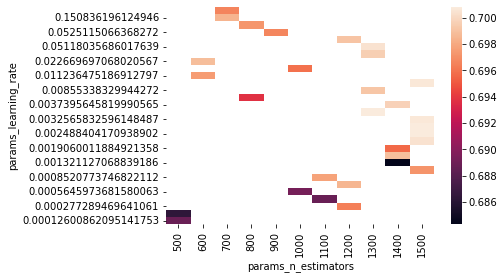

In [44]:

ax = sns.heatmap(trial_results.pivot('params_learning_rate', 'params_n_estimators', 'value'))
ax.invert_yaxis()

In [38]:
temp = X_train.copy()
temp['edu_code'] = temp.name_education_type.astype('category').cat.codes
temp.groupby('name_education_type')['edu_code'].value_counts()

name_education_type            edu_code
Academic degree                0              129
Higher education               1            59992
Incomplete higher              2             8233
Lower secondary                3             3026
Secondary / secondary special  4           174628
Name: edu_code, dtype: int64

In [44]:
fe = HCDefaultFeatureEngineer(featengineer='experiment_b')
fe.fit_transform(X_train)['marital_status'].value_counts()

2    157282
5     36302
4     23772
3     15823
1     12828
6         1
Name: marital_status, dtype: int64

## Experiment Tests

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from lgbm_feature_engineering import HCDefaultFeatureEngineer

exp_grid = {'hcdefaultfeatureengineer__featengineer': ['experiment_a', 'experiment_b']}

exp_pipe = make_pipeline(HCDefaultFeatureEngineer(featengineer='experiment_a'),
                    LGBMClassifier(random_state=42, **study.best_params))

exp_gs = GridSearchCV(exp_pipe,
                      param_grid = exp_grid,
                      scoring = 'roc_auc',
                      cv = 5,
                      n_jobs = -1)

exp_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('hcdefaultfeatureengineer',
                                        HCDefaultFeatureEngineer(featengineer='experiment_a')),
                                       ('lgbmclassifier',
                                        LGBMClassifier(colsample_bytree=0.35,
                                                       learning_rate=0.0063079498520437665,
                                                       max_depth=6,
                                                       min_child_samples=650,
                                                       min_child_weight=15,
                                                       min_split_gain=1.8058245177533558,
                                                       n_estimators=1500,
                                                       num_leaves=114,
                                                       random_state=42,
                                                       reg_a

In [59]:
pd.DataFrame(exp_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hcdefaultfeatureengineer__featengineer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,92.810858,3.648748,43.624544,4.733946,experiment_a,{'hcdefaultfeatureengineer__featengineer': 'ex...,0.721108,0.717131,0.719663,0.717322,0.712071,0.717459,0.003077,2
1,84.557056,12.102277,31.490331,16.086505,experiment_b,{'hcdefaultfeatureengineer__featengineer': 'ex...,0.721541,0.718093,0.719989,0.720048,0.713463,0.718627,0.002804,1


In [27]:
exp_gs.best_estimator_.named_steps.hcdefaultfeatureengineer.feature_set

['ind_cash_loan',
 'ind_male',
 'ind_own_car',
 'ind_own_realty',
 'cnt_children',
 'amt_income_total',
 'amt_credit',
 'amt_goods_price',
 'age',
 'flag_phone',
 'flag_email',
 'cnt_fam_members',
 'region_rating_client',
 'region_rating_client_w_city',
 'reg_city_not_live_city',
 'ext_source_2',
 'days_last_phone_change',
 'flag_document_3',
 'flag_document_6',
 'credit_income_ratio',
 'credit_amt_goods_diff',
 'days_employed',
 'age_started_at_job',
 'days_id_publish',
 'days_registration',
 'days_birth_registration_diff',
 'days_birth_employed_diff',
 'days_birth_id_publish_diff']

## Model Explanations and Feature Importances

In [54]:
X_train_fe = pd.DataFrame(pipe.fit_transform(X_train, y_train), columns = pipe['feat_engineer'].feature_set)
X_train_fe.index = X_train.index

finalized_pipe = Pipeline([x for x in pipe.steps])
finalized_pipe.steps.append(('model', LGBMClassifier(random_state=42, **study.best_params)))
finalized_pipe.fit(X_train, y_train)

Pipeline(steps=[('feat_engineer',
                 HCDefaultFeatureEngineer(featengineer='experiment_a')),
                ('model',
                 LGBMClassifier(colsample_bytree=0.35,
                                learning_rate=0.0063079498520437665,
                                max_depth=6, min_child_samples=650,
                                min_child_weight=15,
                                min_split_gain=1.8058245177533558,
                                n_estimators=1500, num_leaves=114,
                                random_state=42,
                                reg_alpha=0.0018942904146710565,
                                reg_lambda=0.44755400302993353, subsample=0.45,
                                subsample_freq=1))])

In [55]:
shap_explainer = shap.TreeExplainer(finalized_pipe['model'])
shap_values = shap_explainer.shap_values(X_train_fe)

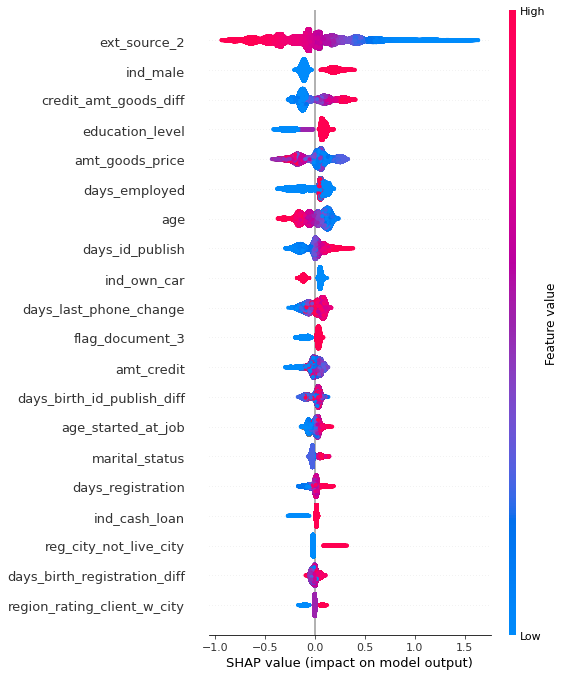

In [56]:
shap.summary_plot(shap_values[1], X_train_fe)

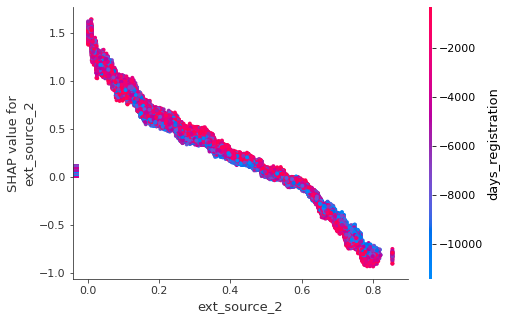

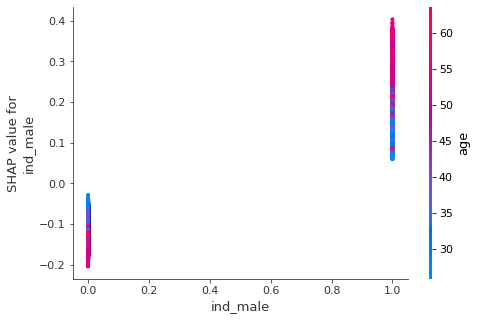

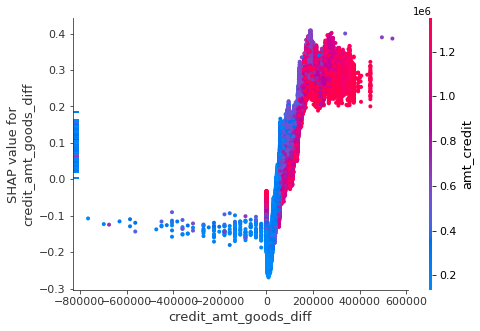

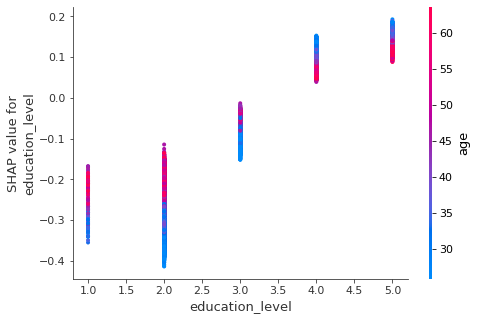

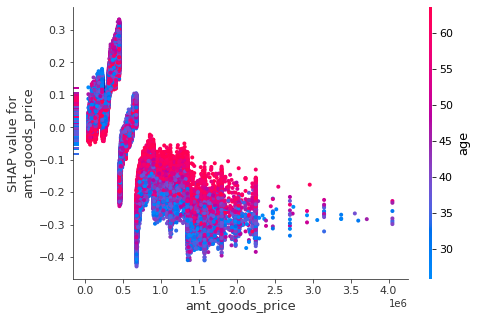

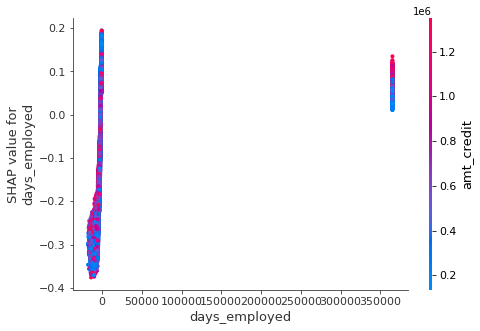

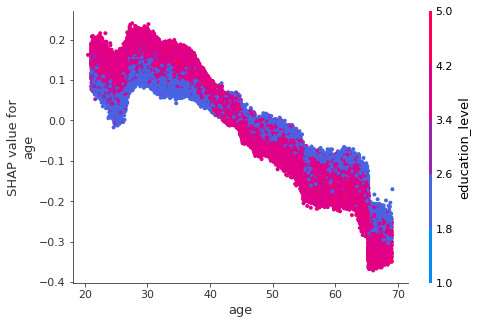

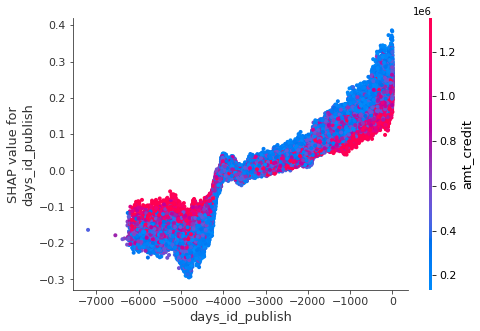

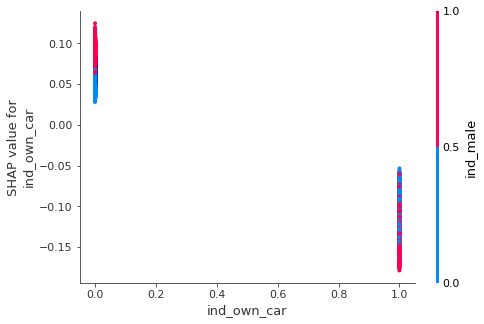

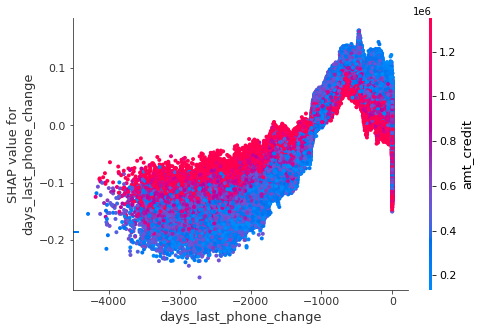

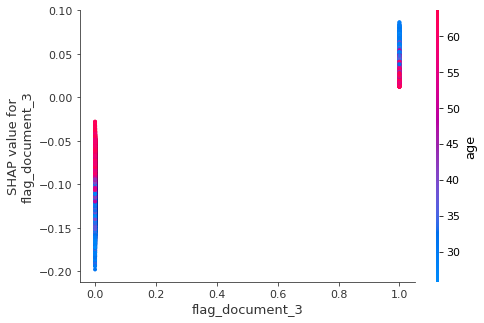

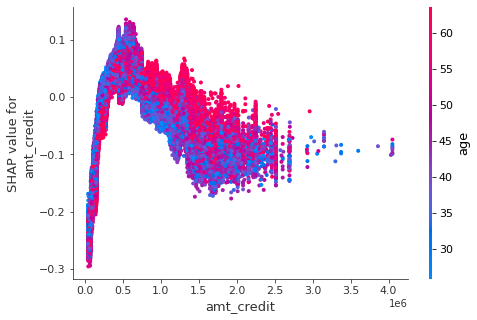

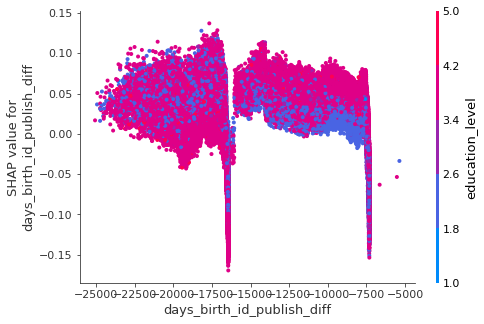

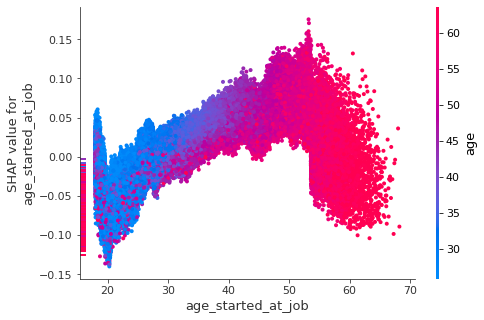

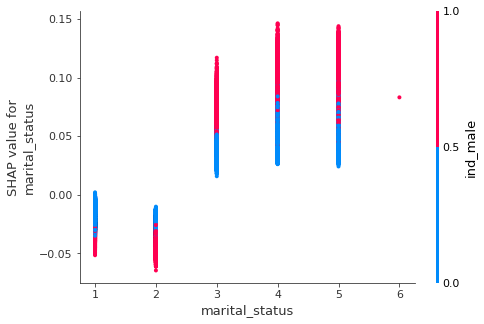

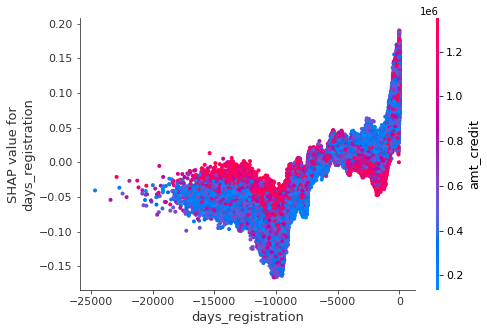

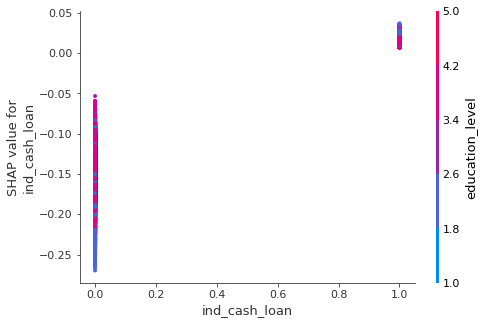

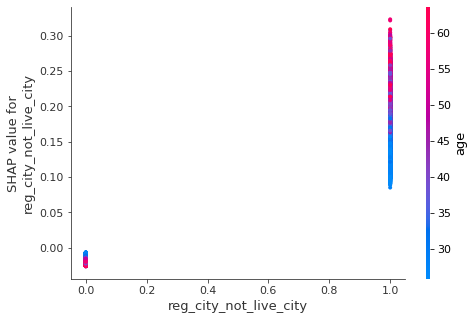

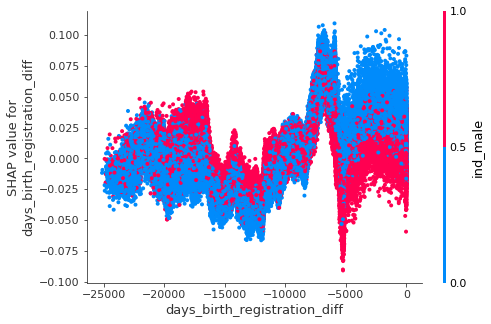

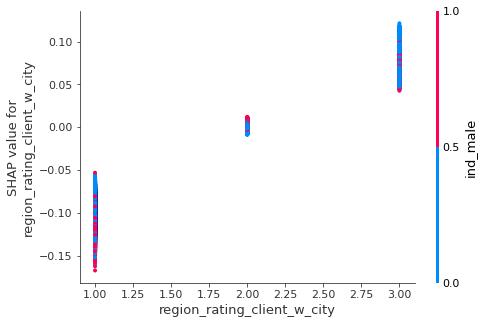

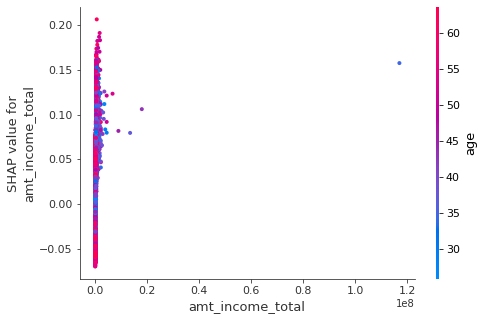

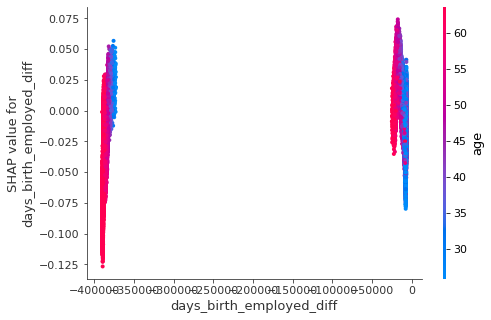

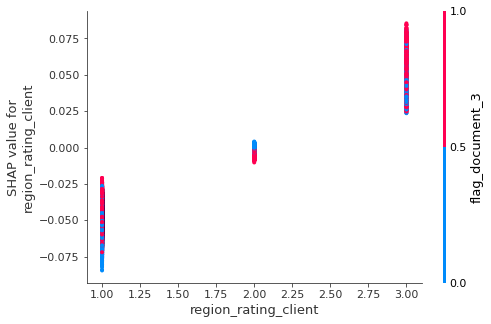

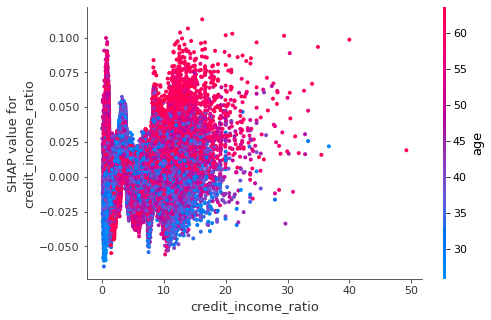

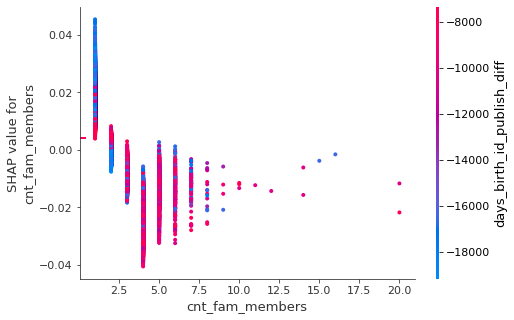

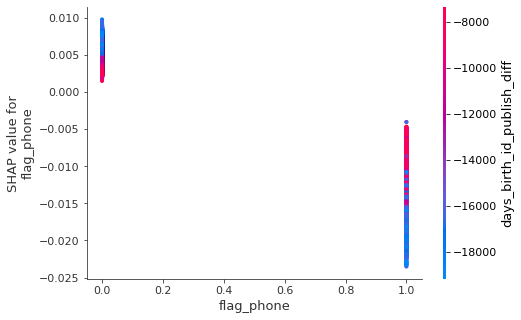

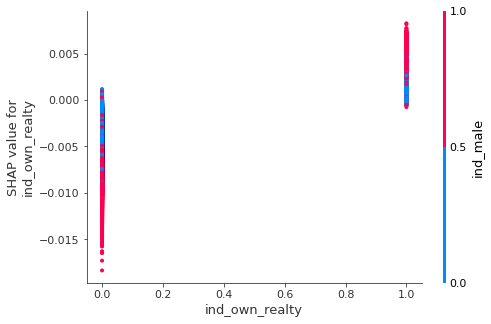

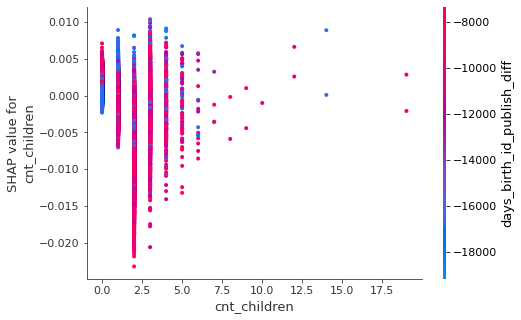

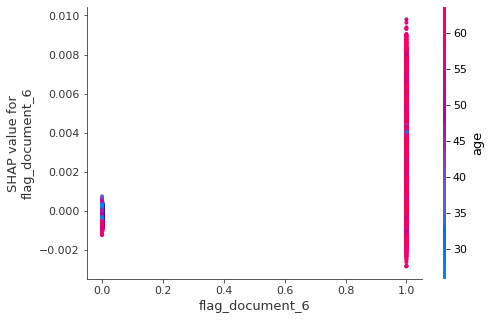

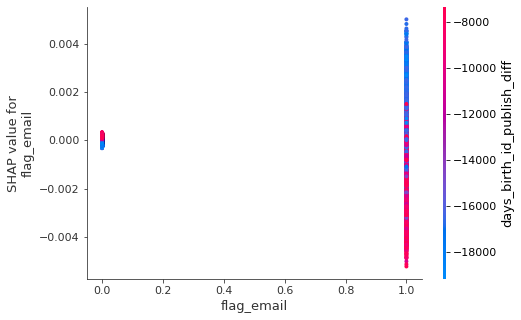

In [57]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))

for i in range(X_train_fe.shape[1]):
    shap.dependence_plot(top_inds[i], shap_values[1], X_train_fe)

### Log Loss for Error Analysis

In [87]:
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  if true_label == 1:
    return -np.log(p)
  else:
    return -np.log(1 - p)

In [125]:
error_df = pd.DataFrame({'sk_id_curr': train.sk_id_curr,
                         'target': y_train,
                          'prob': finalized_pipe.predict_proba(X_train)[:, 1]})

error_df['prob_scaled'] = minmax_scale(error_df.prob)

error_df['log_loss'] = error_df.apply(lambda row: logloss(row['target'], row['prob_scaled']), axis = 1)
error_df['color'] = error_df.target.apply(lambda x: 'blue' if x == 1 else 'red')

(0.0, 10.0)

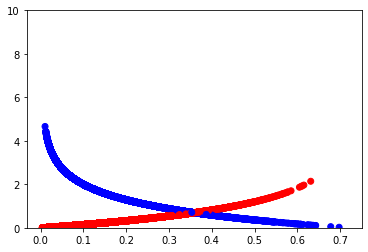

In [130]:
fig, ax = plt.subplots()
ax.scatter(error_df.prob, error_df.log_loss, color = error_df.color)
ax.set_ylim(0, 10)

In [129]:
error_df.sort_values('log_loss')

,sk_id_curr,target,prob,prob_scaled,log_loss,color
153019,453189,0,0.003817,0.000000,9.992007e-16,red
36400,284116,0,0.003902,0.000121,1.206546e-04,red
235652,216584,0,0.004227,0.000578,5.778167e-04,red
188827,148688,0,0.004555,0.001039,1.039757e-03,red
11230,247751,0,0.004581,0.001075,1.075678e-03,red
...,...,...,...,...,...,...
24810,267336,1,0.012341,0.011992,4.423529e+00,blue
214458,185830,1,0.012323,0.011966,4.425728e+00,blue
69659,332355,1,0.012248,0.011861,4.434524e+00,blue
55860,312372,1,0.010542,0.009460,4.660652e+00,blue
